# Aprendizaje automático en Flujos de Datos
Integrantes
- Diego Collado
- Diego López
- Carlota López
- Iñigo González-Varas

In [1]:

from river.drift import ADWIN
from river import forest
from river import tree
import pandas as pd
import seaborn as sns
from river import anomaly
from river import metrics
import matplotlib.pyplot as plt
from river import stats

# Introducción
El análisis de flujos de datos es una técnica emergente en el campo del aprendizaje automático que se utiliza para procesar y analizar grandes volúmenes de datos en tiempo real. A diferencia del aprendizaje automático tradicional, donde el conjunto de datos es estático y se procesa en su totalidad, el análisis de flujos de datos implica la entrada constante de nuevos datos, lo que requiere que los modelos se adapten y actualicen de manera dinámica. En este trabajo, abordaremos el proceso de convertir un conjunto de datos para la predicción de infartos en un flujo de datos y entrenar modelos en este flujo.

# Análisis de datos
El conjunto de datos seleccionado para este estudio se centra en la predicción de infartos, y contiene diversas características relacionadas con la salud del paciente, como edad, género, niveles de glucosa, presión arterial, entre otros. La primera etapa del análisis consistió en visualizar la distribución de los datos en cada una de las características. A través de histogramas y gráficos de conteo, se pudo observar cómo se distribuyen los datos en el conjunto, lo que proporciona una perspectiva inicial sobre la naturaleza de los datos.

In [4]:
data = pd.read_csv("Heart Attack.csv")

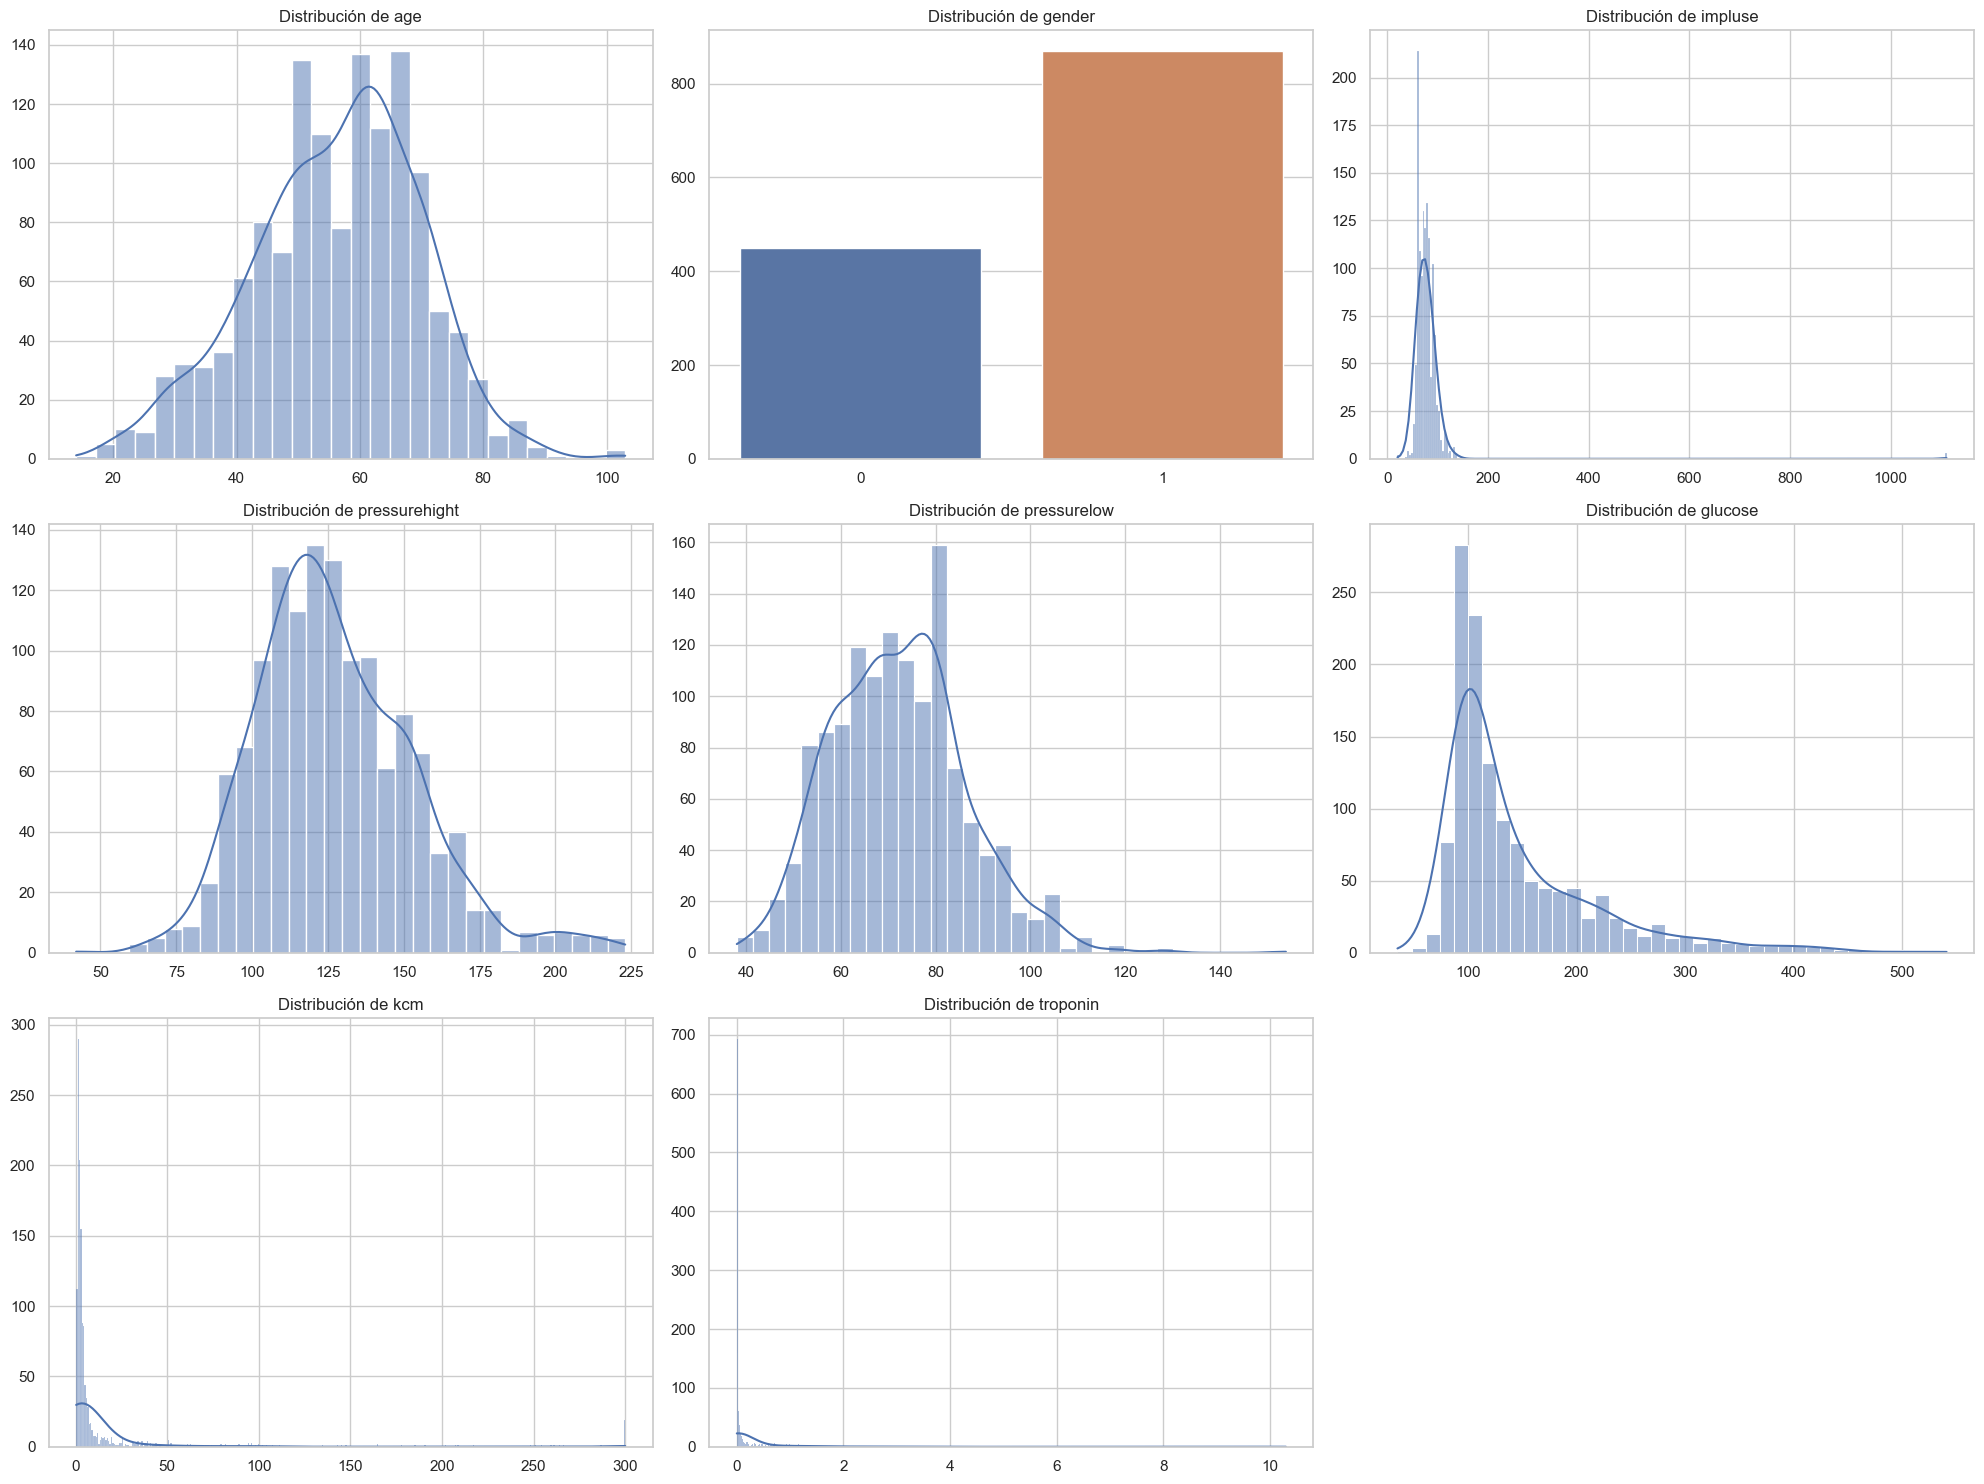

In [5]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(20, 15))
dataplot = data.copy()
# Lista de las columnas a representar
columns = dataplot.columns.drop('class')

# Creamos un subplot para cada columna
for i, column in enumerate(columns, 1):
    plt.subplot(3, 3, i)
    if dataplot[column].dtype == 'object' or column == 'gender':
        sns.countplot(x=column, data=data)
    else:
        sns.histplot(data[column], kde=True)
    plt.title(f'Distribución de {column}')
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

Las gráficas representan distribuciones de diversas variables. 

1. **Age:** Muestra un patrón bimodal con dos grupos de edad predominantes.
2. **Gender:** Hay más registros para el grupo 1 que para el 0.
3. **Pressurehigh y Pressurelow:** Ambas tienen distribuciones cercanas a la normal con sesgos leves.
4. **Impulse:** Concentrada al inicio con una cola larga, indicando outliers.
5. **Glucose:** Centrada en un rango con algunos outliers al extremo derecho.
6. **Kcm y Troponin:** Distribuciones sesgadas hacia la izquierda.

Específicamente, **Impulse** presenta outliers que pueden afectar análisis y modelos, requiriendo atención especial quew veremos mas adelante.

# Modelos de clasificación (sin tratamiento de outliers)
Para el análisis en tiempo real, se utilizaron dos modelos específicos para flujos de datos: el Adaptive Random Forest (ARF) y el Hoeffding Adaptive Tree Classifier. Estos modelos se caracterizan por su capacidad para adaptarse a flujos de datos dinámicos y detectar cambios o desviaciones en los datos a medida que se reciben.

Durante el entrenamiento, cada instancia del conjunto de datos se procesó de forma secuencial. Los modelos realizaron predicciones basadas en los datos actuales y, posteriormente, se actualizaron con la retroalimentación obtenida. Se monitoreó la precisión del modelo a lo largo del tiempo para detectar cualquier fluctuación o cambio significativo en su rendimiento.

Un aspecto clave a destacar es la detección de cambios en el flujo de datos. Si se detecta un cambio o "drift" en el flujo, es una señal de que el modelo puede no estar funcionando de manera óptima bajo las nuevas condiciones de los datos. En nuestro estudio, se empleó ADWIN como detector de cambios, pero en este experimento no se hacia nada al respecto.

primero vamos a ver como funcionan los modelos sin tratar los outliers

*** Warning: Drift detected at instance 223 ***
*** Warning: Drift detected at instance 1055 ***
0.9446550416982562


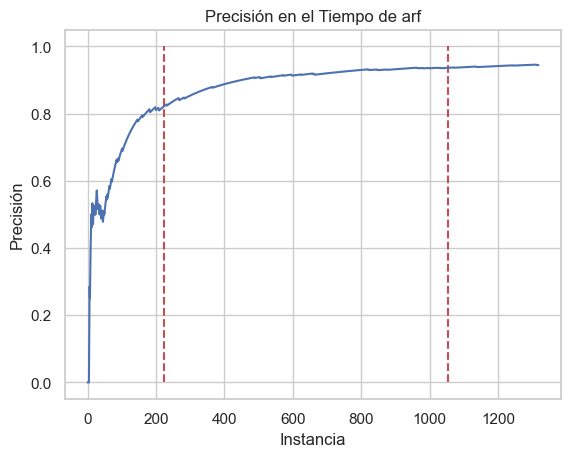

*** Warning: Drift detected at instance 767 ***
0.6997725549658832


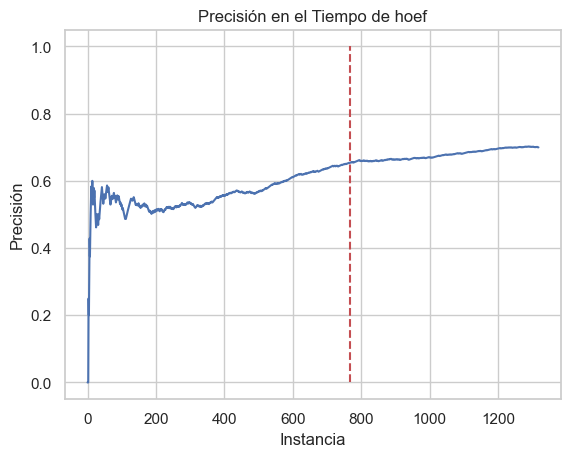

In [202]:
modelos = {
        "arf": forest.ARFClassifier(seed= 8,drift_detector=ADWIN()),       
        "hoef": tree.HoeffdingAdaptiveTreeClassifier(
    drift_detector=ADWIN(),
)
    }

# Inicializar métricas
f1 = metrics.F1()
mcc = metrics.MCC()


    
for nombre, modelo in modelos.items():
    accuracy = metrics.Accuracy()  
    accuracies = []
        
    for i, row in data.iterrows():
        x = row.drop(['class'])
        y = row['class']
        # Detección de outliers

        y_pred = modelo.predict_one(x)
        modelo.learn_one(x, y)
        
        # Actualizar las métricas
        f1.update(y, y_pred)
        mcc.update(y, y_pred)
        accuracy.update(y, y_pred)
        modelo.drift_detector.update(accuracy.get())
        if modelo.drift_detector.drift_detected:
            plt.vlines(i, 0, 1, colors='r', linestyles='dashed')
            
                
            print(f"*** Warning: Drift detected at instance {i} ***")
            #modelo = modelo.clone()
    


    
        accuracies.append(accuracy.get())

 # Crear un gráfico de precisión en el tiempo
    print(accuracy.get())
    plt.plot(range(len(accuracies)), accuracies)
    plt.xlabel("Instancia")
    plt.ylabel("Precisión")
    plt.title(f'Precisión en el Tiempo de {nombre}')
    plt.show()

  
   



Basándonos en las gráficas proporcionadas, podemos realizar las siguientes observaciones y conclusiones:

**Velocidad de Convergencia:**

ARF: La precisión del modelo ARF aumenta rápidamente al principio y alcanza niveles cercanos a 1 en las primeras instancias. Parece converger alrededor del valor 0.94.
Hoeffding: En contraste, el modelo basado en Hoeffding parece tener una convergencia más gradual hacia una precisión estable. A lo largo de las instancias, la precisión aumenta lentamente y parece estabilizarse alrededor del valor 0.7.
La rapidez de convergencia en la precisión favorece claramente al modelo ARF en comparación con el modelo Hoeffding.

**Detección de Cambios de Concepto (Drift Detection):**

ARF: Se detectan dos cambios de concepto en las instancias 223 y 1055.

Hoeffding: Solo se detecta un cambio de concepto en la instancia 767.


**Estabilidad en la Precisión:**

ARF: Tras las detecciones de cambio de concepto, la precisión del modelo ARF muestra cierta volatilidad, pero se recupera rápidamente y sigue siendo alta.
Hoeffding: El modelo Hoeffding muestra más variaciones en su precisión a lo largo del tiempo, y aunque detecta menos drifts, su precisión general es inferior a la del modelo ARF.

**Conclusión:** Basándonos en la rapidez de convergencia en la precisión, el modelo ARF es superior al modelo Hoeffding. Aunque ARF detecta más cambios de concepto, es capaz de adaptarse rápidamente y mantener una alta precisión. El modelo Hoeffding, aunque muestra una adaptabilidad más lenta, podría requerir más datos para alcanzar una precisión similar a la de ARF. 

# Modelos con tratamiento de outliers



**Detección de Outliers:**
Se ha implementado una clase `IQR_Outlier_Detector` para detectar outliers basados en el método IQR (Rango Intercuartílico). Esta clase calcula el primer (Q1) y tercer cuartil (Q3) de los datos y, utilizando estos valores, determina los límites inferior y superior para identificar outliers. Si un valor se encuentra fuera de estos límites, se considera un outlier.

**Proceso del Bucle Principal:**
En el bucle principal, para cada modelo (`arf` y `hoef`), se inicializan las métricas de precisión (`accuracy`). Luego, para cada fila de los datos (`data`):

1. Se extraen las características `x` y la etiqueta `y`.
2. Se actualiza el detector de outliers con el valor del atributo en la posición 2 (posiblemente el atributo "impluse").
3. Se verifica si este valor es un outlier utilizando el método `is_outlier`.
4. Si el valor **no es un outlier**, el modelo hace una predicción `y_pred` para las características `x` y luego se actualiza (entrena) con los datos reales. Las métricas se actualizan con los valores reales y predichos.
5. Si el detector de drift detecta un cambio de concepto en la precisión, se indica con una línea vertical roja en el gráfico y se reinicia el modelo a su estado inicial.
6. Si el valor **es un outlier**, se marca en el gráfico con un punto rojo.

Al final del bucle para un modelo específico, se imprime la precisión final (`ACC`) y se muestra un gráfico que traza la precisión a lo largo del tiempo.

**Resumen:**
Este código realiza un seguimiento del rendimiento de dos modelos de clasificación en un flujo de datos, teniendo especial cuidado de no entrenar los modelos con datos atípicos. Además, los modelos se adaptan dinámicamente a los cambios de concepto en los datos, garantizando que siempre reflejen las tendencias más recientes. Esto es esencial en aplicaciones donde los datos pueden cambiar con el tiempo, como en los sistemas de detección de fraudes o en aplicaciones de comercio electrónico.

*** Warning: Drift detected at instance 237, reseteamos el modelo ***
*** Warning: Drift detected at instance 757, reseteamos el modelo ***
ACC: 0.9022498060512025


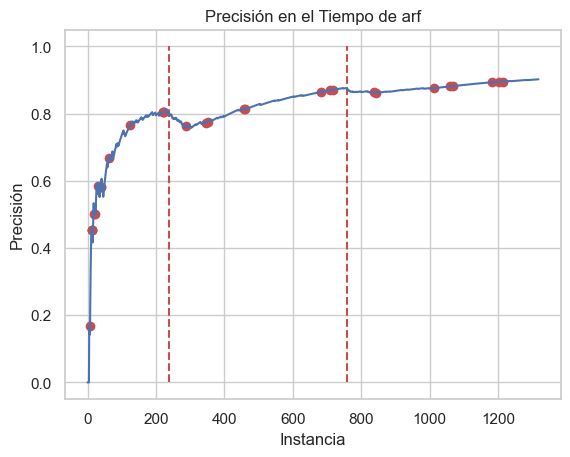

*** Warning: Drift detected at instance 562, reseteamos el modelo ***
ACC: 0.682699767261443


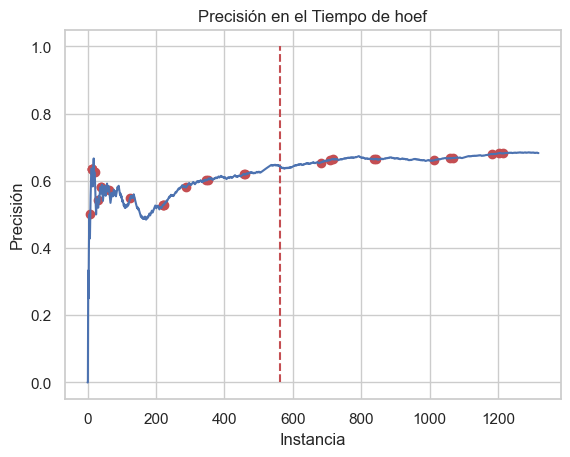

In [203]:
modelos = {
        "arf": forest.ARFClassifier(drift_detector=ADWIN(), seed= 8),       
        "hoef": tree.HoeffdingAdaptiveTreeClassifier(
    drift_detector=ADWIN()
)
    }



class IQR_Outlier_Detector:
    def __init__(self, factor=1.5):
        self.q1 = stats.Quantile(0.25)  # Primer cuartil
        self.q3 = stats.Quantile(0.75)  # Tercer cuartil
        self.factor = factor

    def update(self, value):
        self.q1.update(value)
        self.q3.update(value)

    def is_outlier(self, value):
        iqr = self.q3.get() - self.q1.get()
        lower_bound = self.q1.get() - self.factor * iqr
        upper_bound = self.q3.get() + self.factor * iqr

        return value < lower_bound or value > upper_bound

# Ejemplo de uso

    
for nombre, modelo in modelos.items():
    accuracy = metrics.Accuracy()  
    accuracies = []
    detector = IQR_Outlier_Detector()
      
    for i, row in data.iterrows():
        x = row.drop(['class'])
        y = row['class']
        detector.update(x[2])
        # Detección de outliers
        is_outlier = detector.is_outlier(x[2])
        
        if is_outlier == 0:
            y_pred = modelo.predict_one(x)
            modelo.learn_one(x, y)
            
            # Actualizar las métricas
            f1.update(y, y_pred)
            mcc.update(y, y_pred)
            accuracy.update(y, y_pred)
            modelo.drift_detector.update(accuracy.get())
            if modelo.drift_detector.drift_detected:
                plt.vlines(i, 0, 1, colors='r', linestyles='dashed')
                print(f"*** Warning: Drift detected at instance {i}, reseteamos el modelo ***")
                modelo = modelo.clone()
        
        if is_outlier == 1:
            plt.plot(i, accuracy.get(), 'ro')

    
        accuracies.append(accuracy.get())

 # Crear un gráfico de precisión en el tiempo
    print(f"ACC: {accuracy.get()}")
    plt.plot(range(len(accuracies)), accuracies)
    plt.xlabel("Instancia")
    plt.ylabel("Precisión")
    plt.title(f'Precisión en el Tiempo de {nombre}')
    plt.show()

    

    
   


Observando las gráficas proporcionadas, podemos extraer las siguientes conclusiones:

1. **Rapidez de Convergencia:** Ambos modelos, `arf` y `hoef`, muestran una convergencia más rápida en comparación con los gráficos anteriores. Esto indica que al excluir los outliers, el modelo puede ajustarse de manera más eficiente a la tendencia subyacente de los datos.

2. **Detección de Drift:** En el modelo `arf`, se detectan cambios de concepto en las instancias 237 y 757, mientras que en el modelo `hoef`, el drift se detecta en la instancia 562. Estas detecciones llevan a un reinicio del modelo.

3. **Accuracy General:** A pesar de la rápida convergencia, hay un detalle importante que destacar. Al reiniciar el modelo después de detectar un drift, especialmente en las instancias más avanzadas, no hay suficientes datos posteriores para permitir que el modelo se recupere y alcance los niveles de precisión anteriores. Esto es evidente en el hecho de que después de cada detección de drift, aunque hay una rápida adaptación inicial, la precisión no vuelve a los niveles máximos anteriores.

4. **Comparación entre Modelos:** En términos de precisión final, el modelo `arf` supera ligeramente al modelo `hoef`, alcanzando un `ACC` de aproximadamente 0.902 frente a 0.683 del `hoef`. Sin embargo, ambos modelos muestran tendencias similares en términos de reacción ante los drifts y el impacto posterior en la precisión.

5. **Outliers:** Los puntos rojos dispersos en las gráficas indican instancias donde se detectaron outliers. Es evidente que al no considerar estos valores atípicos para el entrenamiento, los modelos pudieron mantener una tendencia más consistente en su precisión.

**Conclusión:** Excluir outliers y reiniciar los modelos después de detectar un drift permite una rápida adaptación a los cambios en los datos. Sin embargo, este reinicio, especialmente en etapas tardías del flujo de datos, puede ser perjudicial para la precisión general, ya que no hay suficientes datos restantes para que el modelo se recupere completamente. Esto destaca la importancia de equilibrar la adaptabilidad con la retención de conocimientos en aplicaciones de flujo de datos.

# Experimento final: modelo gemelo

En este segmento de código, se han implementado varios cambios y mejoras con el propósito de optimizar el rendimiento de un modelo `ARF` (Adaptive Random Forest) y mejorar la gestión de concept drifts en el flujo de datos. A continuación, se describen y explican los puntos clave del código:

1. **Uso de DDM (Drift Detection Method):** A diferencia del método ADWIN utilizado anteriormente, se ha optado por el uso de DDM para la detección de cambios bruscos en el flujo de datos. DDM permite no solo detectar drifts, sino también advertir sobre posibles drifts inminentes mediante warnings.

2. **Modelo Gemelo (Background Model):** Cuando DDM detecta un warning de drift, es decir, una posible señal de un cambio inminente en el flujo de datos, se inicia el entrenamiento de un modelo gemelo en el background utilizando los datos que generan estas advertencias. De esta manera, en caso de que finalmente se confirme un drift, en lugar de reiniciar el modelo principal desde cero, se sustituye por este modelo gemelo que ya ha estado adaptándose a los nuevos datos.

3. **Ajustes del ARF:** Se han hecho varios ajustes en los parámetros del `ARFClassifier` basados en el dataset reducido que tenemos:
   - `grace_period=25`: Se establece un periodo de gracia de 25 instancias. Esto significa que el modelo esperará 25 instancias antes de intentar dividir un nodo de hoja.
   - `min_branch_fraction=0.04`: Este parámetro evita que se creen ramas indeseadas rápidamente en el árbol, proporcionando una cierta resistencia a las divisiones prematuras.
   - `max_depth=10` y otros parámetros adicionales también se han configurado para optimizar el comportamiento del modelo, especialmente considerando que se cuenta con un conjunto de datos limitado.

4. **Detección de Outliers:** Al igual que en el código anterior, se utiliza el detector de outliers basado en IQR para filtrar y evitar entrenar el modelo con instancias atípicas.

5. **Flujo de Procesamiento:** Durante el proceso de iteración a través del conjunto de datos:
   - Si una instancia no es un outlier, se entrena el modelo `ARF` y se actualizan las métricas.
   - Si se detecta un warning de drift, el modelo gemelo (background model) comienza a entrenarse con esa instancia.
   - Si se confirma un drift, el modelo principal (`ARF`) se reemplaza por el modelo gemelo.


En resumen, este código busca mejorar la adaptabilidad del modelo frente a drifts sin comprometer su precisión. Al utilizar DDM para las advertencias y tener un modelo gemelo preparado en el background, se reduce el impacto negativo de reiniciar completamente el modelo cuando se detectan cambios.

*** Warning: Drift detected at instance 151, reseteamos el modelo ***
ACC: 0.9425911559348332


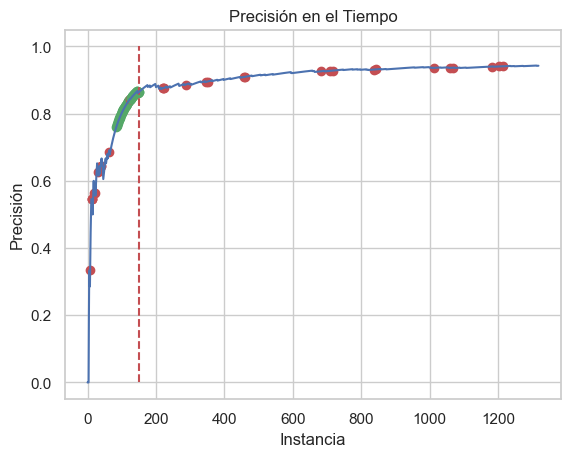

In [204]:
from river.drift import ADWIN
from river import drift
from river import forest
from river import tree
import pandas as pd
from river import anomaly
from river import metrics
import matplotlib.pyplot as plt
from river import stats

# Crear un ARF Classifier
arf = forest.ARFClassifier(seed = 8,max_depth=10,grace_period= 25,min_branch_fraction=0.04,lambda_value=6,leaf_prediction="mc",drift_detector=drift.binary.DDM(), warning_detector= drift.binary.DDM())


# Inicializar métricas

accuracy = metrics.Accuracy()


data = pd.read_csv("Heart Attack.csv")

accuracies = []

class IQR_Outlier_Detector:
    def __init__(self, factor=1.5):
        self.q1 = stats.Quantile(0.25)  # Primer cuartil
        self.q3 = stats.Quantile(0.75)  # Tercer cuartil
        self.factor = factor

    def update(self, value):
        self.q1.update(value)
        self.q3.update(value)

    def is_outlier(self, value):
        iqr = self.q3.get() - self.q1.get()
        lower_bound = self.q1.get() - self.factor * iqr
        upper_bound = self.q3.get() + self.factor * iqr

        return value < lower_bound or value > upper_bound

# Ejemplo de uso
detector = IQR_Outlier_Detector()

background_model = arf.clone()



for i, row in data.iterrows():
    x = row.drop(['class'])
    y = row['class']
    detector.update(x[2])
    # Detección de outliers

    is_outlier = detector.is_outlier(x[2])

    if is_outlier == 0:
        # Entrenar el ARF solo si no es un outlier
        y_pred = arf.predict_one(x)
        arf.learn_one(x, y)
        
        # Actualizar las métricas
        f1.update(y, y_pred)
        mcc.update(y, y_pred)
        accuracy.update(y, y_pred)
        arf.warning_detector.update(accuracy.get())
        arf.drift_detector.update(accuracy.get())
        #adwin_detector.update(accuracy.get())
        if arf.warning_detector.warning_detected:
            plt.plot(i, accuracy.get(),'go')
            
            background_model.learn_one(x, y)
            
        if arf.drift_detector.drift_detected:
        #if adwin_detector.drift_detected:
            plt.vlines(i, 0, 1, colors='r', linestyles='dashed')
            print(f"*** Warning: Drift detected at instance {i}, reseteamos el modelo ***")
            #model = model.clone()
            arf = background_model
        

        

    if is_outlier == 1:
        plt.plot(i, accuracy.get(), 'ro')
    # Calcular la precisión para un solo dato


    
    accuracies.append(accuracy.get())

# Crear un gráfico de precisión en el tiempo
print(f"ACC: {accuracy.get()}")
plt.plot(range(len(accuracies)), accuracies)
plt.xlabel("Instancia")
plt.ylabel("Precisión")
plt.title("Precisión en el Tiempo")
plt.show()


### Conclusiones del modelo final

El gráfico muestra la "Precisión en el Tiempo" de un modelo que procesa un flujo de datos. Hay varios puntos clave a destacar:

1. **Convergencia Rápida:** A diferencia de algunos gráficos anteriores, aquí podemos observar que el modelo alcanza rápidamente una alta precisión poco después de la instancia 0. Esto es un indicador de que el modelo está adaptándose y aprendiendo de manera efectiva a partir de los datos iniciales en el flujo.

2. **Importancia de la Convergencia Rápida en Flujos de Datos:** En escenarios de flujo de datos, la velocidad a la que un modelo se adapta y aprende es crítica por varias razones:
   - **Cambios Dinámicos:** Los flujos de datos a menudo representan entornos que cambian con el tiempo (por ejemplo, mercados financieros, tendencias en redes sociales, sensores en tiempo real, entre otros). Un modelo que converge rápidamente puede responder de manera efectiva a estos cambios, garantizando un rendimiento óptimo en momentos críticos.
   - **Recursos Limitados:** En el procesamiento de flujos de datos, a menudo se trabaja con ventanas de tiempo o conjuntos de datos limitados. No siempre es posible almacenar y procesar todo el historial de datos, por lo que es esencial que el modelo aprenda eficientemente de las instancias más recientes.
   - **Respuestas en Tiempo Real:** En muchas aplicaciones en tiempo real, se necesita que el modelo proporcione predicciones rápidas y precisas. Una rápida convergencia asegura que el modelo está listo para enfrentar desafíos inmediatos sin la necesidad de un largo período de "calentamiento" o adaptación.

3. **Estabilidad Posterior al Drift:** Después de la detección del drift en la instancia 151, notamos que la precisión no sufre una caída drástica y se mantiene estable en valores altos. Esto refuerza la idea de que el enfoque de tener un modelo gemelo en el background es efectivo, ya que permite una transición suave y mantiene la calidad de las predicciones incluso después de un cambio en la distribución de los datos.

En conclusión, la rápida convergencia es esencial en contextos de flujos de datos debido a la naturaleza dinámica y a menudo impredecible de estos entornos. Un modelo que se adapta rápidamente garantiza que siempre se esté operando en un nivel óptimo de rendimiento, independientemente de las variaciones en el flujo de datos.

# Conclusiones finales


A lo largo de nuestra discusión y análisis, hemos explorado diferentes técnicas y enfoques para tratar con flujos de datos en contextos de aprendizaje automático. Basándonos en lo que hemos visto, podemos resumir las siguientes conclusiones:

1. **Detección y Manejo de Drifts:** Es esencial identificar y manejar rápidamente los cambios en las distribuciones de datos. Técnicas como ADWIN y DDM han demostrado ser efectivas para detectar estos drifts, permitiendo a los modelos adaptarse a nuevos escenarios.

2. **Importancia del Aprendizaje en Línea:** Dado que los flujos de datos son continuos y potencialmente infinitos, los modelos de aprendizaje en línea son esenciales. Estos modelos se actualizan constantemente con nueva información, asegurando que siempre sean relevantes y precisos.

3. **Modelos Gemelos y Adaptación:** La idea de entrenar un modelo gemelo en el background es innovadora y efectiva. Permite a los sistemas mantener una alta precisión incluso después de detectar un drift, al intercambiar el modelo principal con uno ya adaptado a los nuevos datos.

4. **Rapidez y Eficiencia:** En entornos de flujo de datos, la velocidad a la que un modelo aprende y se adapta es crítica. Hemos visto la importancia de una convergencia rápida y cómo puede marcar la diferencia en el rendimiento global de un sistema, especialmente en escenarios en tiempo real.

5. **Manejo de Outliers:** No todos los datos en un flujo son necesariamente útiles o relevantes. La detección y el manejo adecuado de outliers es esencial para asegurar que los modelos no sean influenciados negativamente por ruido o anomalías.

6. **Parametrización y Afinación:** La elección adecuada de parámetros, como el grace period o el min_branch_fraction, puede tener un impacto significativo en cómo un modelo se comporta y aprende. Es crucial experimentar y afinar estos parámetros según el contexto específico y la naturaleza de los datos.

En resumen, trabajar con flujos de datos presenta desafíos únicos que requieren enfoques y técnicas especializadas. A través de nuestra discusión, hemos destacado la importancia de la adaptabilidad, la detección rápida de cambios y la capacidad de aprender de manera eficiente. Con las técnicas y estrategias adecuadas, es posible construir sistemas robustos y precisos capaces de manejar la dinámica cambiante de los flujos de datos en tiempo real.